## YOLO + microsam prediction

Import Yolo and setup paths

In [22]:
import numpy as np
import napari
print("Napari version:", napari.__version__)
from pathlib import Path
from segment_everything.weights_helper import get_weights_path
from segment_everything.object_detectors.yolo_detector import YoloDetector

Napari version: 0.6.6


### Load test image

In [23]:
tnia_images_path = Path(r"D:\images")
tnia_images_path = Path(r"/home/bnorthan/images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2025_05_10_SOTA_Test_Set')

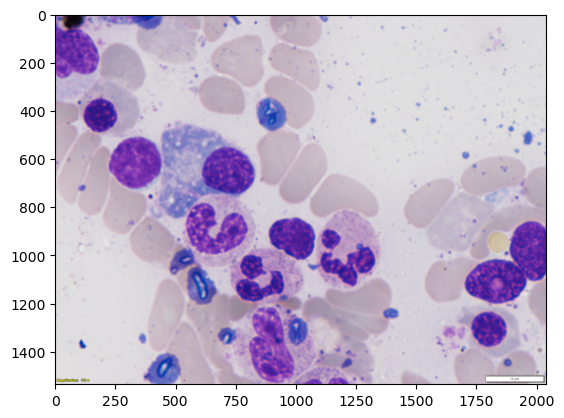

In [24]:
from skimage.io import imread
import matplotlib.pyplot as plt

img = imread(parent_path / r"TestHidden_005.bmp")

# create grayscale only for napari display (temporary napari bug with RGB + 3D labels)
img_grayscale = img.mean(axis=2).astype(np.uint8)

# show original image with matplotlib
plt.imshow(img)

### Detect Bounding Boxes with YOLO

Set up a bounding box detector.  Here I use a Yolo detector vendored from mobilesam, but any bounding box detector would work for this step. 

In [25]:
weights_path = str(get_weights_path("ObjectAwareModel"))
weights_path = str(get_weights_path("ObjectAwareModelHuggingFace"))
yolo_detector_object_aware = YoloDetector(weights_path, "ObjectAwareModelFromMobileSamV2", device='cuda')

Generate bounding boxes with YOLO

In [26]:
results = yolo_detector_object_aware.get_results(img, conf=0.2, imgsz=2048)


0: 1568x2048 106 objects, 212.8ms
Speed: 10.6ms preprocess, 212.8ms inference, 1.2ms postprocess per image at shape (1, 3, 2048, 2048)


Get the classes and the bounding boxes from the Yolo result.  Convert bbox to Napari and Microsam format. 

TODO: move this code to a utility

In [27]:
'''
classes = results[0].boxes.cls.cpu().numpy()

# get xyxy boxes
bboxes_yolo=results[0].boxes.xyxy.cpu().numpy()

# convert to [[y1,x1], [y2,x2]] for napari and [x1,y1,x2,y2] for microsam
bboxes_microsam = []
boxes_napari = []
for box in bboxes_yolo:
    bbox_napari = [[box[1], box[0]], [box[3], box[2]]]
    boxes_napari.append(bbox_napari)
    bbox_microsam = [box[1], box[0], box[3], box[2]]
    bboxes_microsam.append(bbox_microsam)
'''

'\nclasses = results[0].boxes.cls.cpu().numpy()\n\n# get xyxy boxes\nbboxes_yolo=results[0].boxes.xyxy.cpu().numpy()\n\n# convert to [[y1,x1], [y2,x2]] for napari and [x1,y1,x2,y2] for microsam\nbboxes_microsam = []\nboxes_napari = []\nfor box in bboxes_yolo:\n    bbox_napari = [[box[1], box[0]], [box[3], box[2]]]\n    boxes_napari.append(bbox_napari)\n    bbox_microsam = [box[1], box[0], box[3], box[2]]\n    bboxes_microsam.append(bbox_microsam)\n'

In [28]:
# New: use YoloDetector helpers to get boxes in the desired formats (non-destructive)
# These should produce the same results as the manual loop above.

bboxes_microsam = yolo_detector_object_aware.get_microsam_bboxes(img, conf=0.2, imgsz=2048)
boxes_napari = yolo_detector_object_aware.get_napari_bboxes(img, conf=0.2, imgsz=2048)

print(f"microsam boxes (new API): {len(bboxes_microsam2)}")
print(f"napari boxes (new API): {len(boxes_napari2)}")

# show first box for quick comparison
if len(bboxes_microsam2) > 0:
    print("explicit microsam box:", bboxes_microsam[0])
    print("api microsam box:", bboxes_microsam2[0])
    print()
    print("explicit napari box:", boxes_napari[0])
    print("api napari box:", boxes_napari2[0])

# Optionally, you can pass bboxes_microsam2 directly to the mask detector:
# mask_list2 = detector.segment_boxes(bboxes_microsam2)
# stacked_labels2 = StackedLabels(mask_list2)
# labels2 = stacked_labels2.get_3d_labels()
# viewer.add_labels(labels2, name='labels_new', scale=(3,1,1))


Predicting bounding boxes for image data


0: 1568x2048 106 objects, 213.0ms
Speed: 11.2ms preprocess, 213.0ms inference, 1.2ms postprocess per image at shape (1, 3, 2048, 2048)



Predicting bounding boxes for image data


0: 1568x2048 106 objects, 213.4ms
Speed: 10.5ms preprocess, 213.4ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)


microsam boxes (new API): 106
napari boxes (new API): 106
explicit microsam box: [np.float32(350.3869), np.float32(117.9552), np.float32(490.52222), np.float32(257.366)]
api microsam box: [np.float32(350.3869), np.float32(117.9552), np.float32(490.52222), np.float32(257.366)]

explicit napari box: [[np.float32(350.3869), np.float32(117.9552)], [np.float32(490.52222), np.float32(257.366)]]
api napari box: [[np.float32(350.3869), np.float32(117.9552)], [np.float32(490.52222), np.float32(257.366)]]


### Use microsam for mask generation

In [29]:
from segment_everything.stacked_labels import StackedLabels
from segment_everything.mask_detectors.microsam import microsam_detector

detector = microsam_detector(model_type="vit_b_lm", device='cpu')
detector.set_image(img)
mask_list = detector.segment_boxes(bboxes_microsam)


Compute Image Embeddings 2D: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


In [30]:
stacked_labels = StackedLabels(mask_list)
labels = stacked_labels.make_3d_labels()


In [31]:
viewer = napari.Viewer()
viewer.add_image(img_grayscale, name='image')
viewer.add_labels(labels, name='labels', scale=(3,1,1))

<Labels layer 'labels' at 0x76a098820dd0>

In [32]:
shapes_layer = viewer.add_shapes(name='bboxes', face_color= 'transparent', edge_color='green', edge_width=3)

for bbox_microsam in boxes_napari:
    shapes_layer.add_rectangles([bbox_microsam])

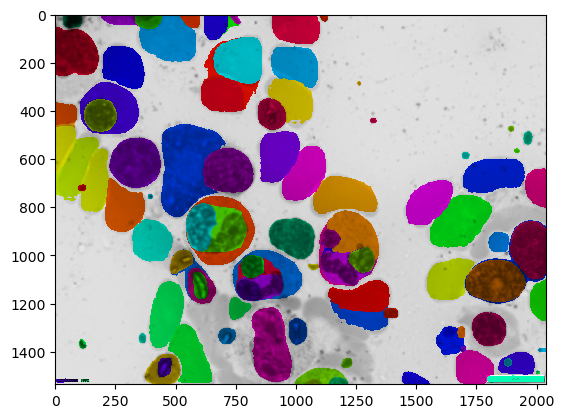

In [33]:
from tnia.plotting.plt_helper import mask_overlay


test = stacked_labels.make_2d_labels(type="max")

plt.imshow(mask_overlay(img, test))

In [34]:
# append empty zero slice to labels 

temp = np.zeros((1, viewer.layers['labels'].data.shape[1], viewer.layers['labels'].data.shape[2]))
temp = temp.astype(viewer.layers['labels'].data.dtype)

viewer.layers['labels'].data = np.concatenate([viewer.layers['labels'].data, temp], axis=0)
